## **Problem Set 1: Attitude, Rigid Body, Lagrange**

#### **Problem №1: Lie Integration**

Consider the kinematics of a rotating body parametrized with quaternions, as described by the following ODE:

$$
\dot{\mathbf{q}} = \frac{1}{2}\mathbf{q} \otimes \hat{\boldsymbol{\omega}}
$$

where $\mathbf{q} \in \mathbb{S}^3$ is the unit quaternion and $\hat{\boldsymbol{\omega}} = [0, \boldsymbol{\omega}]$ is the "angular velocity quaternion" with $\boldsymbol{\omega} \in \mathbb{R}^3$ being the angular velocity.

Do the following:

* **[10 points]** When selecting a random angular velocity $\boldsymbol{\omega}$, use either the forward or backward Euler method to simulate the motion of the system. Afterwards, check the norm of the quaternion, plot trajectories, and animate the motion, then discuss the results.
* **[10 points]** Instead of Euler integration, apply the following technique: $\mathbf{q}_{k+1} = \mathbf{q}_k \otimes \text{exp}(\frac{1}{2}\hat{\boldsymbol{\omega}}_kdt)$, where $\text{exp}(\mathbf{q})$ is the **quaternion exponential**. Check the norm of the quaternion, plot the trajectories, animate the motion, and compare the results with Euler integration.

---


In [9]:
# integrators
import numpy as np


def forward_euler(f, x0, N, dt):
    x = np.zeros((N, len(x0)))
    x[0] = x0
    for i in range(N-1):
        x[i+1] = x[i] + dt * f(x[i])
    return x


def exp_q(q):
    # function returns exp(q)
    tolerance = 1e-17
    v_norm = np.linalg.norm(q[1:])
    vec = q[1:]
    if v_norm > tolerance:
        vec = vec / v_norm

    magnitude = np.exp(q[0])
    return np.hstack([[magnitude * np.cos(v_norm)], magnitude * vec * np.sin(v_norm)])


def quat_product(p, q):
    Q = np.array([
        [p[0], -p[1], -p[2], -p[3]],
        [p[1], p[0], -p[3], p[2]],
        [p[2], p[3], p[0], -p[1]],
        [p[3], -p[2], p[1], p[0]],
    ])
    return Q @ q


def quaternion_exponential(q0, w, N, dt):
    q = np.zeros((N, 4))
    q[0] = q0
    w = np.array([0, w[0], w[1], w[2]])
    for i in range(N-1):
        q[i+1] = quat_product(q[i], exp_q(0.5 * w * dt))
    return q

# quaternions utilities


def quat_rm(q):
    # returns rotation matrix for quaternion
    r00 = q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2
    r01 = 2 * (q[1] * q[2] - q[0] * q[3])
    r02 = 2 * (q[1] * q[3] + q[0] * q[2])

    r10 = 2 * (q[1] * q[2] + q[0] * q[3])
    r11 = q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2
    r12 = 2 * (q[2] * q[3] - q[0] * q[1])

    r20 = 2 * (q[1] * q[3] - q[0] * q[2])
    r21 = 2 * (q[2] * q[3] + q[0] * q[1])
    r22 = q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2

    return np.array([
        [r00, r01, r02],
        [r10, r11, r12],
        [r20, r21, r22],
    ])


def quat_rot(theta, v_vec, direction):
    # theta is the angle of rotation
    # v_vec is the vector to be rotated
    # direction is the axis of rotation
    v = np.hstack([[0], v_vec])
    u = direction / np.linalg.norm(direction)
    q = np.hstack([[np.cos(theta / 2)], u * np.sin(theta / 2)])
    q_conj = np.hstack([[np.cos(theta / 2)], -u * np.sin(theta / 2)])

    vprime = quat_product(q, quat_product(v, q_conj))
    return quat_rm(vprime)


def skew(v):
    # returns skew symmetric matrix for vector v
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0],
    ])


def Rq(q):
    # return matrix for integrating quaternion
    return np.array([
        [-q[1], -q[2], -q[3]],
        [q[0], q[3], -q[2]],
        [-q[3], q[0], q[1]],
        [q[2], -q[1], q[0]],
    ])


In [17]:
# problem 1

# chosen angular velocity
w = np.array([0, 0, 30])

# w = np.random.rand(3)
# w = w / np.linalg.norm(w)

# initial conditions
q0 = np.array([1, 0, 0, 0])
dt = 1e-3
t = np.linspace(0, 10.0, int(10.0 / dt))
N = len(t)

q = forward_euler(lambda q: 0.5 * Rq(q) @ w.T, q0, N, dt)

rm = np.zeros((N, 3, 3))
for i in range(N):
    rm[i] = quat_rm(q[i])


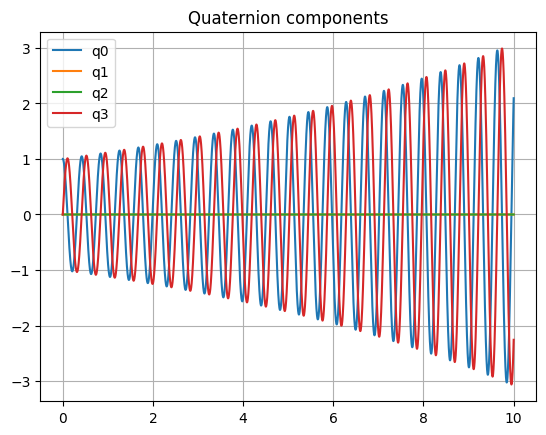

In [18]:
import matplotlib.pyplot as plt

# show quaternion components
plt.title('Quaternion components')
plt.plot(t, q[:, 0], label='q0')
plt.plot(t, q[:, 1], label='q1')
plt.plot(t, q[:, 2], label='q2')
plt.plot(t, q[:, 3], label='q3')
plt.grid()
plt.legend()
plt.show()

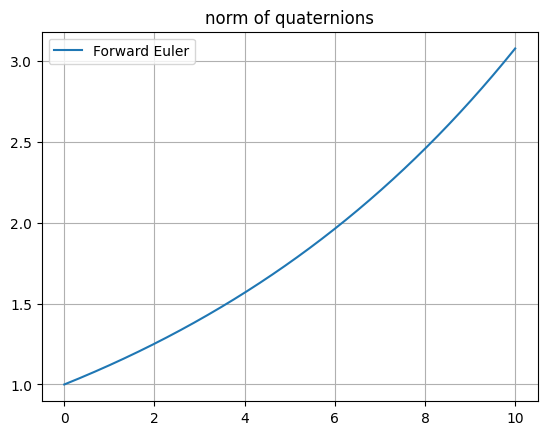

In [19]:
import matplotlib.pyplot as plt

# show norms of quaternions
plt.title('norm of quaternions')
plt.plot(t, np.linalg.norm(q, axis=1), label='Forward Euler')
plt.legend()
plt.grid()
plt.show()


In [20]:
import json
with open('vis-data/problem1_forward.json', 'w') as f:
    output = np.hstack([t.reshape(-1, 1), rm.reshape(-1, 9)])

    json.dump(output.tolist(), f)


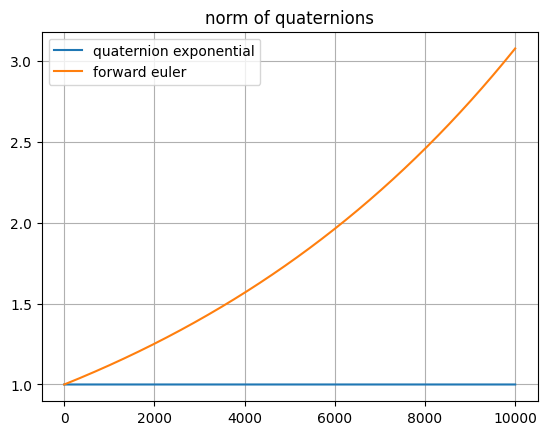

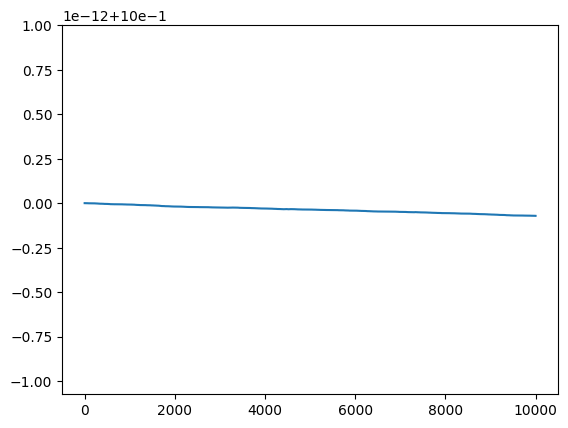

In [21]:
# problem 1.2 try integrate with quaternion exponential

q2 = quaternion_exponential(q0, w, N, dt)

rm2 = np.zeros((N, 3, 3))
for i in range(N):
    rm2[i] = quat_rm(q2[i])

import matplotlib.pyplot as plt

# show norms of quaternions
plt.title('norm of quaternions')
plt.grid()
plt.plot(np.linalg.norm(q2, axis=1), label='quaternion exponential')
plt.plot(np.linalg.norm(q, axis=1), label='forward euler')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.linalg.norm(q2, axis=1))

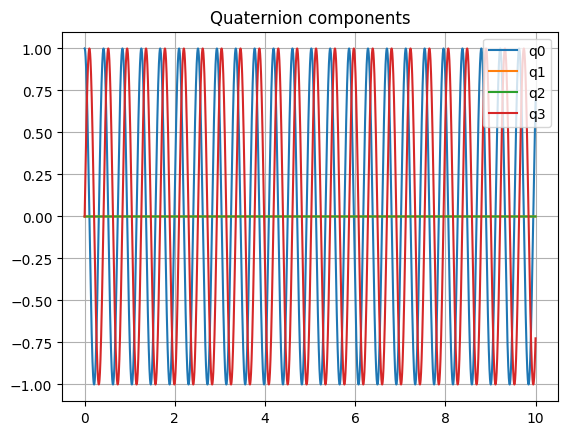

In [22]:
import matplotlib.pyplot as plt

# show quaternion components
plt.title('Quaternion components')
plt.plot(t, q2[:, 0], label='q0')
plt.plot(t, q2[:, 1], label='q1')
plt.plot(t, q2[:, 2], label='q2')
plt.plot(t, q2[:, 3], label='q3')
plt.grid()
plt.legend()
plt.show()

In [23]:
import json
with open('vis-data/problem1_exp.json', 'w') as f:
    output = np.hstack([t.reshape(-1, 1), rm2.reshape(-1, 9)])

    json.dump(output.tolist(), f)